In [122]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import time
import statsmodels.api as sm
import openpyxl

# Define your path
path = "/Users/v.d Bosch/Documents/Github/Forecast_evaluation/"

## Plot functions of nonlinear models

In [5]:
def TR_model(S_t, gamma):
    # Return a vector of outcomes of the TR model
    return (S_t >= gamma).astype(float).reshape(-1, 1)

def LSTR_model(S_t,gamma,tau):
    # Return a vector of outcomes of the LSTR model
    return ((1+np.exp(-tau * (S_t-gamma)))**-1).reshape(-1, 1)

def ESTR_model(S_t,gamma,tau):
    # Return a vector of outcomes of the ESTR model
    return (1-np.exp(-tau * (S_t-gamma)**2)).reshape(-1, 1)

def nonlin_model(model_type, S_t, gamma, tau):
    
    # Detect which model type it should use according to model_type
    if (model_type == "TR"):
        return TR_model(S_t,gamma)
        
    elif (model_type == "LSTR"):
        return LSTR_model(S_t,gamma,tau)
        
    elif (model_type == "ESTR"):
        return ESTR_model(S_t,gamma,tau)
        
    # If we pass another model that is not included, we give an error
    else:
        raise Exception("Model type unknown")

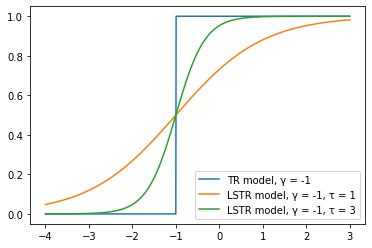

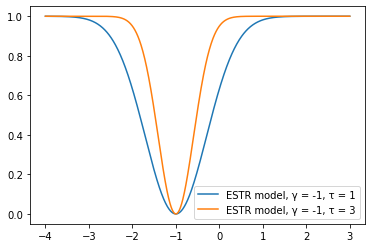

In [112]:
#set global variables for the plots
partitions = 1000
start = -4
finish = 3

#define parameters
gamma_array = np.array([-1])

#plot all nonlinear functions for each parameter
for gamma in gamma_array:
    sns.lineplot(x=np.linspace(start,finish,partitions),
                 y=TR_model(np.linspace(start,finish,partitions),gamma).T[0],
                 label="TR model, \u03B3 = "+str(gamma))

#define parameters
gamma_array = np.array([-1])
tau_array = np.array([1,3])

#plot all nonlinear functions for each parameter
for gamma in gamma_array:
    for tau in tau_array:
        sns.lineplot(x=np.linspace(start,finish,partitions),
                     y=LSTR_model(np.linspace(start,finish,partitions),gamma,tau).T[0],
                     label="LSTR model, \u03B3 = "+str(gamma)+", \u03C4 = "+str(tau))
plt.show()

#define parameters
gamma_array = np.array([-1])
tau_array = np.array([1,3])

#plot all nonlinear functions for each parameter
for gamma in gamma_array:
    for tau in tau_array:
        sns.lineplot(x=np.linspace(start,finish,partitions),
                     y=ESTR_model(np.linspace(start,finish,partitions),gamma,tau).T[0],
                     label="ESTR model, \u03B3 = "+str(gamma)+", \u03C4 = "+str(tau))
plt.show()

# Analyze simulation 1

In [6]:
def cal_g_theta_TR(S_t, # Vector of S_t
                L_t, # Vector of loss function
                R_size, # Integer
                P_size, # Integer
                T_size, # Integer
                ):

    # Initialize the critical values with a minimum value 
    crit_values = np.full(iterations_CV,-100)

    # Create an array of gamma value that are used in the for loop
    gamma_quantile = np.linspace(0.15,0.85,grid_elements)

    # Get Q_t
    Q_t = np.stack([np.column_stack((np.ones((T_size,1)),np.multiply(np.ones((T_size,1)),
                                                                     TR_model(S_t,np.quantile(S_t,gamma_quantile[i])))))
                                                                     for i in range(grid_elements)])
    
    # Get psi
    psi = np.stack(estimateBeta(Q_t[i,R_size-1:R_size+P_size-1],L_t) for i in range(grid_elements))
    
    # Select values of Q_t
    Q_sel = np.transpose(np.lib.stride_tricks.sliding_window_view(Q_t,R_size,axis=1)[:,:P_size],(0,1,3,2))

    # Calculate the residuals
    residual_sel = L_t - Q_sel[:,:,-1] @ psi

    # Calculate the score and its transpose
    score = Q_sel[:,:,-1] * residual_sel
    score_trans = np.transpose(score, (0, 2, 1))
    
    # Compute V_P, M_P, and its inverse
    V_P = np.transpose(score,(0,2,1)) @ score / P_size
    M_P = np.transpose(Q_sel[:,:,-1],(0,2,1)) @ Q_sel[:,:,-1] / P_size
    M_P_inv = np.stack(np.linalg.inv(M_Ps) for M_Ps in M_P)
    
    # Get V_star and its inverse
    V_star = M_P_inv @ V_P @ M_P_inv
    V_star_inv = np.stack(np.linalg.inv(V_stars) for V_stars in V_star)

    # Then it is possible to calculate W_P
    W_P = P_size * (np.transpose(psi,(0,2,1)) @ V_star_inv @ psi)

    # Get the test statistic of all W_P values
    g_theta = max(W_P)[0][0]

    # This part simulates the critical values, initialize the barlett kernel:
    if (barlett_kernel == False):
        B_size = 0
    
    else:    
        B_size = round(4*(P_size/100)**(2/9)+1)

    # Simulate a matrix of the standard normal distribution
    v_t = np.random.normal(0,1,(P_size+B_size,iterations_CV))
    
    # Calculate lambda_sum and lambda_P
    lambda_sum = score_trans @ np.transpose(np.sum(np.array([np.lib.stride_tricks.sliding_window_view(v_t,P_size,axis=0)[b,:] 
                                                             for b in range(0,B_size+1)]),axis=0))
    lambda_P = np.transpose(lambda_sum / (P_size*(1+B_size))**0.5,(0,2,1))

    # Get the collection of critical values
    W_P_j = np.sum(np.matmul(lambda_P, M_P_inv @ V_star_inv @ M_P_inv) * lambda_P,axis=2)    
    crit_values = np.max(W_P_j,axis=0)

    # Sort the Monte Carlo simulations and get the final critical value
    crit_values = np.sort(crit_values)

    final_crit_value = crit_values[round((1-signi_level) * iterations_CV)-1]
    
    # Check if the test statistic should be rejected or not
    if (g_theta > final_crit_value):
        return 1,g_theta,final_crit_value
    else:
        return 0,g_theta,final_crit_value

In [8]:
# Simple method to estimate the OLS estimates
def estimateBeta(Z_t,Y_t):
    return np.linalg.inv(np.transpose(Z_t) @ Z_t) @ np.transpose(Z_t) @ Y_t

In [7]:
def MonteCarlo_iteration_1(R_size,P_size,T_size):
    # Sometimes the method has an error, because there is a singular matrix
    try:
        
        # Simulate the model
        sim_z1, sim_z2, sim_y_t, sim_S_t = sim_model_1(T_size)

        # Calculate the corresponding lost function of interest
        delta_L = cal_delta_L_1(sim_z1, sim_z2, sim_y_t, R_size, P_size,T_size)
    
        # Perform the test on the simulated data for a certain model
        if (model_type=="TR"):
            return cal_g_theta_TR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="LSTR"):
            return cal_g_theta_LSTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="ESTR"):
            return cal_g_theta_ESTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        # If we pass another model that is not included, we give an error
        else:
            raise Exception("Model type unknown")
    
    # If there is a LinAlgError, than we want to re-do the method
    except np.linalg.LinAlgError as e:

        return MonteCarlo_iteration_1(R_size, P_size, T_size)


def sim_model_1(T_size):

    # Initialize delta1, delta2 and v
    delta1 = delta2 = v = 1

    # Simulate the model
    z1 = np.random.normal(0,1,(T_size,1))
    z2 = np.random.normal(0,1,(T_size,1))
    S_t = np.random.normal(0,1,(T_size,1))
    
    # Calculate the dependent variable
    y_t = v + delta1 * z1 + delta2 * z2 + np.random.normal(0, 1, (T_size,1))

    # Return parameter vectors
    return z1, z2, y_t, S_t


def cal_delta_L_1(sim_z1, sim_z2, sim_y_t, R_size, P_size, T_size):
    
    # Compile z1 and z2
    sim_z1 = np.column_stack([np.ones((T_size,1)),sim_z1])
    sim_z2 = np.column_stack([np.ones((T_size,1)),sim_z2])
    
    # Initialize the loss function of interest
    delta_L = np.zeros((P_size,1))
    
    # Loop over all t
    for t in range(R_size, T_size):
        
        # Select the parameters for a certain time period
        z1_sel = sim_z1[t-R_size:t-1]
        z2_sel = sim_z2[t-R_size:t-1]
        y_sel = sim_y_t[t-R_size:t-1]
        
        # Estimate the linear regression estimates
        beta_1 = estimateBeta(z1_sel,y_sel)
        beta_2 = estimateBeta(z2_sel,y_sel)

        # Estimate the two forecasts
        forecast1 = beta_1[0] + sim_z1[t,1] * beta_1[1]
        forecast2 = beta_2[0] + sim_z2[t,1] * beta_2[1]

        # Perform the test of equal predictive ability
        delta_L[t-R_size] = (sim_y_t[t] - forecast1)**2 - (sim_y_t[t] - forecast2)**2
    
    # Return the vector of the loss function of interest
    return delta_L

In [9]:
def MonteCarlo_1_analyse(R,P,T):
    
    if (parallelization == True):    
        # Define variable to keep track of amount of rejects
        Results = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration_1)(R,P,T) for i in range(MC_iterations))
        
        # Get everything out of the Results
        MC_array = np.array([result[0] for result in Results])
        g_theta_array = np.array([result[1] for result in Results])
        crit_value_array = np.array([result[2] for result in Results])
        
    else:
        MC_array = np.zeros(MC_iterations)    
        g_theta_array = np.zeros(MC_iterations)
        crit_value_array = np.zeros(MC_iterations)
        
        # Define variable to keep track of amount of rejects
        for i in range(MC_iterations):
            MC_array[i], g_theta_array[i], crit_value_array[i] = MonteCarlo_iteration_1(R,P,T)    
    
    sns.scatterplot(x=crit_value_array,y=g_theta_array,s=13,color='mediumblue')
    sns.lineplot(x=[-100,100],y=[-100,100],color='red',linestyle='--')
    plt.xlim(5.3,12.7)
    plt.ylim(-0.5,30.5)
    plt.xlabel("Critital Value")
    plt.ylabel("Test Statistic")
    plt.show()

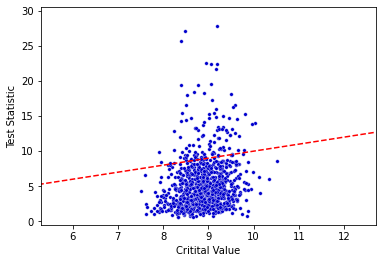

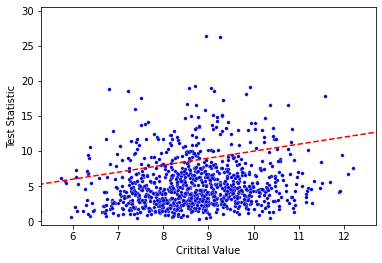

In [114]:
#simulation speed:
MC_iterations = 2000
grid_elements = 20
iterations_CV = 1000
signi_level = 0.05

# Adjustable variables
parallelization = True
barlett_kernel = False

model_type = "TR"

# Values for P, R and T
R_MC = 50
P_MC = 50
T_MC = R_MC + P_MC

MonteCarlo_1_analyse(R_MC,P_MC,T_MC)

barlett_kernel = True
# # Values for P, R and T
# R_MC = 50
# P_MC = 200
# T_MC = R_MC + P_MC

MonteCarlo_1_analyse(R_MC,P_MC,T_MC)

# Random Walk

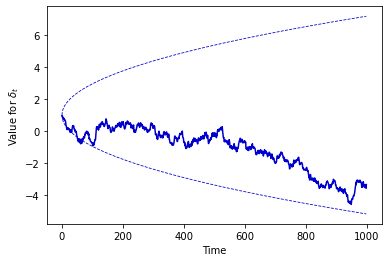

In [96]:
steps = 1000
mean = 0
std = 0.1
steps = np.random.normal(0,std, size=steps)
    
lower_bounds = 1 - 1.96 * std * np.sqrt(np.arange(0,1000))
upper_bounds = 1 + 1.96 * std * np.sqrt(np.arange(0,1000))
random_walk = np.cumsum(steps)+1

sns.lineplot(data=random_walk,color='mediumblue')
sns.lineplot(data=lower_bounds,linestyle="--",color='mediumblue',linewidth=0.8)
sns.lineplot(data=upper_bounds,linestyle="--",color='mediumblue',linewidth=0.8)
plt.xlabel("Time")
plt.ylabel(r"Value for $\delta_t$")
plt.show()

# Scatterplot

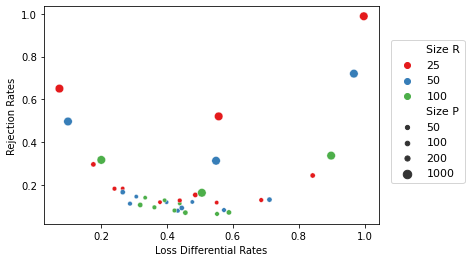

In [147]:
result_names = openpyxl.load_workbook(path + "Results_Sim3.xlsx").sheetnames
results_sim3 = pd.read_excel(path + "Results_Sim3.xlsx",index_col=0, sheet_name=result_names)

df = pd.DataFrame()

P_array = np.array([50,100,200,1000])
R_array = np.array([25,50,100])
for P in P_array:
    for R in R_array:
        
        new_rows = {"Rejection Rates" : results_sim3['Rejection Rates'].loc[R,P].tolist(), 
                    "Loss Differential Rates" : results_sim3['Loss Differential Rates'].loc[R,P].tolist(),
                    "Size P" : P, "Size R" : R} 
        df = df.append(pd.DataFrame(new_rows),ignore_index=True)

fig, ax = plt.subplots()

sns.scatterplot(data=df, x ="Loss Differential Rates",y="Rejection Rates",hue="Size R",palette='Set1',size="Size P")

pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width, pos.height])
ax.legend(bbox_to_anchor=(1.02, 0.87),prop={'size':11},ncol=1) 

# Time-Varying nonlinear model

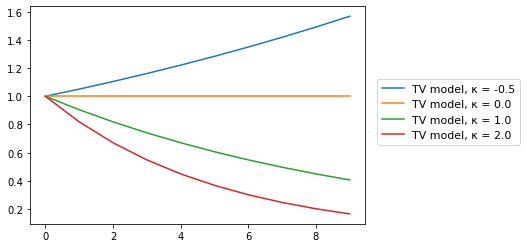

In [45]:
fig, ax = plt.subplots()

kappa_array = np.array([-0.5,0,1,2])
for kappa in kappa_array:
    sns.lineplot(x=np.arange(T),
                 y=np.exp(-kappa * np.arange(0,T)/T),
                 label="TV model, \u03BA = "+str(kappa))
    
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width, pos.height])
ax.legend(bbox_to_anchor=(1.02, 0.69),prop={'size':11},ncol=1) 

In [10]:
def TV_TR_model(S_t, gamma,kappa,T_size):
    return ((S_t >= gamma).astype(float) / (np.exp(kappa*np.arange(0,T_size)/T_size).reshape(T_size,1))).reshape(-1, 1)

def TV_LSTR_model(S_t,gamma,tau,kappa,T_size):
    return ((1+np.exp(-tau * (S_t-gamma)))**-1).reshape(-1, 1) /(np.exp(kappa*np.arange(0,T_size)/T_size).reshape(T_size,1))

def TV_ESTR_model(S_t,gamma,tau,kappa,T_size):
    return (1-np.exp(-tau * (S_t-gamma)**2)).reshape(-1, 1) /(np.exp(kappa*np.arange(0,T_size)/T_size).reshape(T_size,1))

In [16]:
def cal_g_theta_TV_TR(S_t, # Vector of S_t
                L_t, # Vector of loss function
                R_size, # Integer
                P_size, # Integer
                T_size, # Integer
                ):

    # Initialize the critical values with a minimum value 
    crit_values = np.full(iterations_CV,-100)

    # Create two arrays of gamma and kappa values that are used in the for loop
    gamma_quantile = np.tile(np.linspace(0.15,0.85,grid_elements),grid_elements)
    kappa_array = np.repeat(np.linspace(0,2,grid_elements),grid_elements)
    
    # Get Q_t
    Q_t = np.stack([np.column_stack(((np.exp(-kappa_array[i]*np.arange(0,T_size)/T_size).reshape(T_size,1)),TV_TR_model(S_t,np.quantile(S_t,gamma_quantile[i]),kappa_array[i],T_size)))
                                                                     for i in range(grid_elements**2)])

    # Get psi
    psi = np.stack(estimateBeta(Q_t[i,R_size-1:R_size+P_size-1],L_t) for i in range(grid_elements**2))

    # Select values of Q_t
    Q_sel = np.transpose(np.lib.stride_tricks.sliding_window_view(Q_t,R_size,axis=1)[:,:P_size],(0,1,3,2))

    # Calculate the residuals
    residual_sel = L_t - Q_sel[:,:,-1] @ psi

    # Calculate the score and its transpose
    score = Q_sel[:,:,-1] * residual_sel
    score_trans = np.transpose(score, (0, 2, 1))
    
    # Compute V_P, M_P, and its inverse
    V_P = np.transpose(score,(0,2,1)) @ score / P_size
    M_P = np.transpose(Q_sel[:,:,-1],(0,2,1)) @ Q_sel[:,:,-1] / P_size
    M_P_inv = np.stack(np.linalg.inv(M_Ps) for M_Ps in M_P)
    
    # Get V_star and its inverse
    V_star = M_P_inv @ V_P @ M_P_inv
    V_star_inv = np.stack(np.linalg.inv(V_stars) for V_stars in V_star)

    # Then it is possible to calculate W_P
    W_P = P_size * (np.transpose(psi,(0,2,1)) @ V_star_inv @ psi)

    # Get the test statistic of all W_P values
    g_theta = max(W_P)[0][0]
    
    # This part simulates the critical values, initialize the barlett kernel:
    if (barlett_kernel == False):
        B_size = 0
    
    else:    
        B_size = round(4*(P_size/100)**(2/9)+1)

    # Simulate a matrix of the standard normal distribution
    v_t = np.random.normal(0,1,(P_size+B_size,iterations_CV))
    
    # Calculate lambda_sum and lambda_P
    lambda_sum = score_trans @ np.transpose(np.sum(np.array([np.lib.stride_tricks.sliding_window_view(v_t,P_size,axis=0)[b,:] 
                                                             for b in range(0,B_size+1)]),axis=0))
    lambda_P = np.transpose(lambda_sum / (P_size*(1+B_size))**0.5,(0,2,1))

    # Get the collection of critical values
    W_P_j = np.sum(np.matmul(lambda_P, M_P_inv @ V_star_inv @ M_P_inv) * lambda_P,axis=2)    
    crit_values = np.max(W_P_j,axis=0)
    
    # Sort the Monte Carlo simulations and get the final critical value
    crit_values = np.sort(crit_values)

    final_crit_value = crit_values[round((1-signi_level) * iterations_CV)-1]
    
    # Check if the test statistic should be rejected or not
    if (g_theta > final_crit_value):
        return 1,g_theta,final_crit_value
    else:
        return 0,g_theta,final_crit_value

In [194]:
def MonteCarlo_iteration_7(R_size,P_size,T_size,c):
    # Sometimes the method has an error, because there is a singular matrix
    try:
        
        # Simulate the model
        sim_z1, sim_z2, sim_y_t, sim_S_t = sim_model_1(T_size)

        # Calculate the old corresponding lost function of interest
        delta_L_1 = cal_delta_L_1(sim_z1, sim_z2, sim_y_t, R_size, P_size, T_size)
        
        # Normalize delta_L_1
        delta_L_1 = delta_L_1 / np.std(delta_L_1)
        
        # Calculate the new corresponding lost function of interest
        delta_L = cal_delta_L_7(delta_L_1,sim_S_t[R_size-1:T_size-1],T_size,R_size,c)
    
        # Perform the test on the simulated data for a certain model
        if (model_type=="TR"):
            return cal_g_theta_TR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="LSTR"):
            return cal_g_theta_LSTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="ESTR"):
            return cal_g_theta_ESTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
        
        elif (model_type=="TV-TR"):
            return cal_g_theta_TV_TR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="TV-LSTR"):
            return cal_g_theta_TV_LSTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="TV-ESTR"):
            return cal_g_theta_TV_ESTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        # If we pass another model that is not included, we give an error
        else:
            raise Exception("Model type unknown")
        
    # If there is a LinAlgError, than we want to re-do the method
    except np.linalg.LinAlgError as e:

        return MonteCarlo_iteration_7(R_size, P_size, T_size)


def cal_delta_L_7(delta_L_old,S_sel,T_size,R_size,c):
    
    # Initialize gamma
    gamma = 0
    
    # Determine mu and theta by a choice of c
    mu = np.linspace(0,1,c_length)[c]
    theta = -2*mu
    
    # Calculate the new loss function of interest
    delta_L = delta_L_old + mu + theta * TR_model(S_sel,gamma)

    delta_L = delta_L / (np.exp(1 * np.arange(T_size)/T_size)[R_size-1:T_size-1]).reshape(-1,1)

    # Return the loss function of interest
    return delta_L

In [143]:
def MonteCarlo_7_analyze(R_size,P_size,T_size,c):
    
    if (parallelization == True):    
        # Define variable to keep track of amount of rejects
        Results = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration_7)(R_size,P_size,T_size,c) for i in range(MC_iterations))
        
        # Get everything out of the Results
        MC_array = np.array([result[0] for result in Results])
        g_theta_array = np.array([result[1] for result in Results])
        crit_value_array = np.array([result[2] for result in Results])
        
    else:
        MC_array = np.zeros(MC_iterations)    
        g_theta_array = np.zeros(MC_iterations)
        crit_value_array = np.zeros(MC_iterations)
        
        # Define variable to keep track of amount of rejects
        for i in range(MC_iterations):
            MC_array[i], g_theta_array[i], crit_value_array[i] = MonteCarlo_iteration_7(R_size,P_size,T_size,c)      
    print(np.mean(MC_array))
#     sns.scatterplot(x=crit_value_array,y=g_theta_array,s=13,color='mediumblue')
    
    sns.lineplot(x=np.arange(0.01,100,0.01),y=np.arange(0.01,100,0.01),color='red',linestyle='--')
    plt.yscale('log')
    sns.scatterplot(x=crit_value_array,y=g_theta_array,s=13,color='mediumblue')
    plt.xlim(5,24)    
    plt.ylim(0.3,2000)
    plt.xlabel("Critital Value")
    plt.ylabel("Test Statistic")
    plt.show()

0.875


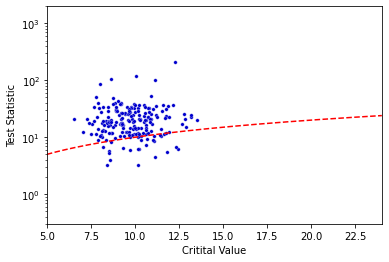

KeyboardInterrupt: 

In [136]:
# Global variables that determine the accuracy of the outcome
MC_iterations = 200
grid_elements = 20
iterations_CV = 1000
c_length = 11

# Global variable to set the significance level
signi_level = 0.05

# Values for P to loop over
c_array = np.arange(c_length)

# Initiliaze R
R_MC = 50

# Adjustable variables
parallelization = True
barlett_kernel = True

# Initialize empty array
rejection_array = np.zeros(c_length)

# Determine the rejection rate of the models given the model and P = 50
P_MC = 50
T_MC = P_MC + R_MC


model_type = "TR"
signi_level = 0.035
MonteCarlo_7_analyze(R_MC,P_MC,T_MC,5)

model_type = "TV-TR"
signi_level = 0.008
MonteCarlo_7_analyze(R_MC,P_MC,T_MC,5)

In [192]:
def Rsquared_analyze(R_size,P_size,T_size,c):
    
    if (parallelization == True):    
        # Define variable to keep track of amount of rejects
        Results = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration_Rsquared)(R_size,P_size,T_size,c) for i in range(MC_iterations))
        
        # Get everything out of the Results
        Rsquared_kappa0 = np.array([result[0] for result in Results])
        Rsquared_kappa1 = np.array([result[1] for result in Results])
        
    else:
        Rsquared_kappa0 = np.zeros(MC_iterations)
        Rsquared_kappa1 = np.zeros(MC_iterations)
        
        # Define variable to keep track of amount of rejects
        for i in range(MC_iterations):
            Rsquared_kappa0[i], Rsquared_kappa1[i] = MonteCarlo_iteration_Rsquared(R_size,P_size,T_size,c)      
    
    print("The average R^2 when kappa is 0 is ",np.mean(Rsquared_kappa0))
    print("The average R^2 when kappa is 1 is ",np.mean(Rsquared_kappa1))
    
def MonteCarlo_iteration_Rsquared(R_size,P_size,T_size,c):
    # Sometimes the method has an error, because there is a singular matrix
    try:
        
        # Simulate the model
        sim_z1, sim_z2, sim_y_t, sim_S_t = sim_model_1(T_size)

        # Calculate the old corresponding lost function of interest
        delta_L_1 = cal_delta_L_1(sim_z1, sim_z2, sim_y_t, R_size, P_size, T_size)
        
        # Normalize delta_L_1
        delta_L_1 = delta_L_1 / np.std(delta_L_1)
        
        # Calculate the new corresponding lost function of interest
        delta_L = cal_delta_L_7(delta_L_1,sim_S_t[R_size-1:T_size-1],T_size,R_size,c)
    
        # Perform the test on the simulated data for a certain model        
        Q_t = np.column_stack((np.ones((T_size,1)),TV_TR_model(sim_S_t,0,0,T_size)))
        Rsquared_kappa0 = sm.OLS(delta_L,Q_t[R_size-1:R_size+P_size-1]).fit().rsquared
        
        Q_t = np.column_stack((np.exp(-1*np.arange(0,T_size)/T_size).reshape(T_size,1),TV_TR_model(sim_S_t,0,1,T_size)))
        Rsquared_kappa1 = sm.OLS(delta_L,Q_t[R_size-1:R_size+P_size-1]).fit().rsquared

        return Rsquared_kappa0, Rsquared_kappa1
        
    # If there is a LinAlgError, than we want to re-do the method
    except np.linalg.LinAlgError as e:

        return MonteCarlo_iteration_1(R_size, P_size, T_size)

In [202]:
# Global variables that determine the accuracy of the outcome
MC_iterations = 5000
c_length = 11
c_array = np.arange(c_length)

# Adjustable variables
parallelization = True

# Initialize empty array
rejection_array = np.zeros(c_length)

# Values for P to loop over
R_MC_array = [25,50,100]
P_MC_array = [50,100,200,1000]


for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        Rsquared_analyze(R_MC,P_MC,T_MC,5)

For R = 25
And P = 50
The average R^2 when kappa is 0 is  0.1987846973684921
The average R^2 when kappa is 1 is  0.22685702908241068
For R = 25
And P = 100
The average R^2 when kappa is 0 is  0.19389888530636032
The average R^2 when kappa is 1 is  0.21504723065055423
For R = 25
And P = 200
The average R^2 when kappa is 0 is  0.18980756011288327
The average R^2 when kappa is 1 is  0.207922699810803
For R = 25
And P = 1000
The average R^2 when kappa is 0 is  0.18585700360378746
The average R^2 when kappa is 1 is  0.20150301883578345
For R = 50
And P = 50
The average R^2 when kappa is 0 is  0.2017311027478753
The average R^2 when kappa is 1 is  0.22343589274237147
For R = 50
And P = 100
The average R^2 when kappa is 0 is  0.1946857601614341
The average R^2 when kappa is 1 is  0.21174233259758501
For R = 50
And P = 200
The average R^2 when kappa is 0 is  0.1917869283427366
The average R^2 when kappa is 1 is  0.20680184637902949
For R = 50
And P = 1000
The average R^2 when kappa is 0 is  0.